# Classifying and Analyzing Binary Stars Using Photometric Data
### Ana Lyons and Narek Stepanian
#### Physics 77 Fall 2018
For our project, we wanted to study eclipsing binary stars, and figure out how to get information about the system out of it's light curve.

### First of all, what are eclipsing binary stars, and why do we study them?
Eclipsing binary stars are a pair of stars gravitationally bound to each other. As observed from Earth, as they orbit each other, each star appears to eclipse the other. Because we can get information about the period, relative brightness, radii and temperature ratio of the system just from observing the pattern of eclipses, binaries make useful very stellar laboratories. 

![alt-text](https://cdn.iflscience.com/images/f0092578-7e1f-520d-b82f-edaafef123cc/extra_large-1464366118-1362-eclipsing-binary-could-be-a-supernova-model.jpg)
*Credit: Marisa Grove, Institute of Astronomy.*

### What types of data can we collect on binary stars?
There are a couple ways to observe binary stars:
* Spectrometry and Radial Velocity Curves:
    * The spectra of the component stars are observed (specifically the black spectral lines). Based on the red/blueshift observed in the spectral lines, the speed of each star at different points in orbit can be determined. In addition, the temperature of each component can be determined from the spectra.
    
![alt text](https://www.quizover.com/ocw/mirror/col11992/m59899/OSC_Astro_18_02_Radial.jpg)
*Credit: QuizOver.com*
    

* Photometric Observation:
    * Here, instead of looking at spectra, one observes the total amount of light coming from the binary system. By plotting the change in light over time, you obtain something called a light curve (as shown below). 

![alt text](http://www.daviddarling.info/images/eclipsing_binary.jpg)
*Credit: ESA*

![alt text](https://www.ocf.berkeley.edu/~mhill/kic3557421/lightcurves.png)
*Credit: San Diego State, University of California Berkeley, California State University at San Bernardino*

In our project, we focused on analyzing photometric data taken from the [KEPLER Eclipsing Binary Catalog](http://keplerebs.villanova.edu/about). First step in analyzing the data is to properly visualize it- by plotting flux (light) versus time. 


## Plotting

In [1]:
#preamble
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.optimize import curve_fit, fmin
import gatspy
%matplotlib inline

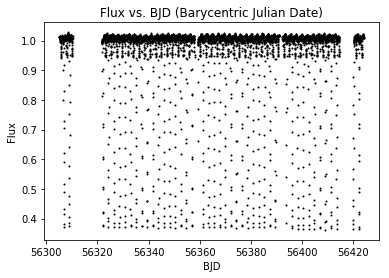

In [11]:
data = np.loadtxt('lc4.data', unpack = 'True') #loading an example data set
time = data[0, :]
flux = data[6, :]
sigma = data[7, :]

plt.plot(time, flux, 'ko', markersize = 1)
plt.title('Flux vs. BJD (Barycentric Julian Date)')
plt.xlabel('BJD')
plt.ylabel('Flux')
plt.show()

As we can see, that looks pretty messy. It's very hard to see any periodicity or get any useful idea of the system from this graph. To get a better graph, we need to 'phase-fold' the data.
We can think of phase as an indicator of where in the period we are. At the beginning, we are at phase = 0. Halfway through the period, we are at phase = 0.5.
To obtain the period of the data, we used a method called Lomb-Scargle frequency decomposition.

### Finding The Period of the Data: 
In order to determine the period of the stars orbit, fourier analysis can be used to detect the frequency that contributes the most to the lightcurve. However, typical datasets present the data in a noncontinuous fashion which can cause difficulty when trying to implement a simple fourier analysis. Therefore, an analytical method must be used which takes into account the lack of continuity in the time axis: the Lomb-Scargle Periodogram.

End of Period Range: 2.3


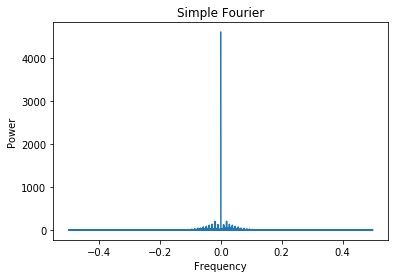

Finding optimal frequency:
 - Estimated peak width = 0.0529
 - Using 5 steps per peak; omega_step = 0.0106
 - User-specified period range:  0.01 to 2.3
 - Computing periods at 59185 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


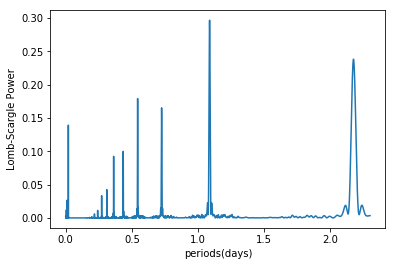

('Period is:', 2.1749507895151727)


In [12]:
data = np.loadtxt('lc4.data', unpack = 'True')
P1 = input('End of Period Range: ')

t = data[0,0:5000]
mag = data[6,0:5000] #flux
dmag = data[7,0:5000] #error on flux

#Simple Fourier Analysis
pre_power = np.fft.fft(mag)
pre_freq = np.fft.fftfreq(t.shape[-1])
plt.plot(pre_freq,abs(pre_power))
plt.title('Simple Fourier')
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

#Lomb-Scargle Method
periods = np.linspace(0.0000001,P1,10000) #range of manually inputed periods to test
model = gatspy.periodic.LombScargle().fit(t,mag,dmag) 
power = model.score(periods)

fig,ax = plt.subplots()
ax.plot(periods, power)
ax.set(xlabel ='periods(days)',ylabel='Lomb-Scargle Power')

model.optimizer.period_range=(.01,P1) #accuracy depends on scale of manually inputed range
period = model.best_period  
period_true = period*2
plt.show()

print('Period is:', period_true)

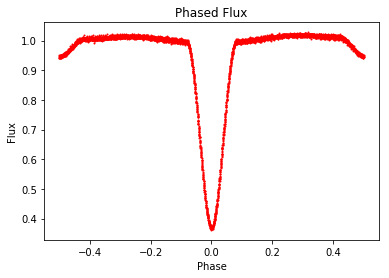

In [13]:
period = period_true #period given by kepler database
t0 = time[list(flux).index(min(flux))] + (period*0.5) #centering phase graph on the primary minimum

#calculating phase (decimal portion of time elapsed/period)
phase = []
for t in time:
    p = abs((t-t0)/period - int((t-t0)/period))
    phase.append(p)

phase_arr = np.array(phase)
phase_arr = phase_arr - 0.5

#phased graph
plt.figure()
plt.plot(phase_arr, flux, 'ro', markersize = 1)
plt.title('Phased Flux')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.show()

As you can see, this is much nicer to look at! We can clearly see the periodic nature of the light coming from the star. This is the graph that we will use to fit an analytical function. 

Note: The phase is plotted from -0.5 to 0.5 This is by convention: we set the primary (or deepest) minimum to phase = 0.


## Curve Fitting:

In [5]:
def make_fourier(N, m0):
    '''Creates a fourier model with N harmonics for eclipsing binary 
    light curve(sum of sines and cosines).
    Inputs: N (number of harmonics), integer
            m0 (average amplitude of flux), float
    Output: a function that takes x (phase data)
            and *a (array of coefficients)'''
    def fourier(x,*a):
        f = m0
        for i in range(0, N):
            f += a[i]*np.cos((i+1)*2*np.pi*x)
        for i in range(N, N + N):
            f += a[i]*np.sin((i+1)*2*np.pi*x)
        return f
    return fourier

chi^2/d.f. = 556.231


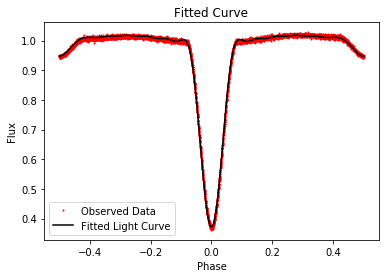

In [14]:
N = 15
m = sp.mean(flux)
par0 = [0.02]*2*N
par, cov = curve_fit(make_fourier(N, m), phase_arr, flux, par0)

#two coefficients we will use to classify the system
a2 = par[1] 
a4 = par[3]

x = np.linspace(-0.5, 0.5, 1000)
y = (make_fourier(15, m))(x, *par)
plt.plot(phase_arr, flux, 'ro', markersize = 1)
plt.plot(x, y, 'k')
plt.title('Fitted Curve')
plt.xlabel('Phase')
plt.ylabel('Flux')
plt.legend(['Observed Data', 'Fitted Light Curve'])

chi_squared = np.sum(((((make_fourier(N, m))(phase_arr, *par)) - flux)/sigma)**2)
reduced_chi_squared = (chi_squared)/(len(phase_arr)-len(par))
print ('chi^2/d.f. = {:5.3f}'.format(reduced_chi_squared))

Ordinarily, after fitting a curve, you want to compute the chi-squared value to get an idea of whether you have found
a good fit or not. However, in this case, a chi-squared statistic is not very useful by itself. 
Instead, we simulate a new data set based on our model, taking into account the errors in the measurements and the average spread of the data around our curve. Then, we perform another fit, and if our chi-squared value for our simulated data is close to our original one, then we know we have a sufficient fit!

In [15]:
#defining some useful functions 
def data_spread(phases, fluxes, N, par):
    '''Given a dataset, gives average spread of data around fitted curve.
    Inputs: phases, fluxes (arrays)
    Outputs: average spread around model (fourier fitted curve), float'''
    m0 = sp.mean(fluxes)
    size = int(len(phases)/N)
    markers = []
    n = 0
    while (size*n) <= len(phases):
        markers.append(size*n)
        n+=1
    if markers[-1] != len(phases):
        markers.append(len(phases))

    sort_index = np.argsort(phases)
    phases = phases[sort_index]
    fluxes = fluxes[sort_index]

    spreads = []
    for i in range(len(markers)-1):
        r = range(markers[i], markers[i+1])
        model = (make_fourier(15, m0))(phases[r], *par)
        interval = fluxes[r]
        diff = interval - model
        spread = max(diff) - min(diff)
        spreads.append(spread)
    spread_avg = sp.mean(spreads)
    return spread_avg


chi^2/d.f. = 563.497


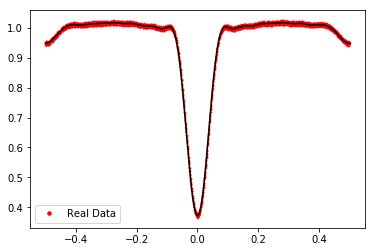

In [16]:
#plotting original data set so we can see how it compares
#plt.plot(phase_arr, flux, 'bo', markersize = 0.5)

#finding average spread of our data around our original model
spread_avg = data_spread(phase_arr, flux, 100, par)

#creating the new data set
x = np.linspace(-0.5, 0.5, len(phase_arr))
simulated_data = (make_fourier(15, m))(x, *par) + spread_avg*np.random.uniform(-0.5, 0.5, len(x)) + sigma[0]*np.random.randn(len(x))

#plotting our simulated data set
plt.plot(x, simulated_data, 'ro', markersize=0.5)
plt.legend(['Real Data', 'Simulated Data'], markerscale = 7)

#fitting a new synthetic light curve to our simulated data
N = 15
m0 = sp.mean(simulated_data)
par0 = [0.02]*2*N
par_1, cov_1 = curve_fit(make_fourier(N, m0), x, simulated_data, par0)

#plotting new model
x1 = np.linspace(-0.5, 0.5, 500)
y1 = (make_fourier(N, m0))(x1, *par_1)
plt.plot(x1, y1, 'k')

#finding new chi-squared statistics
fit = (make_fourier(N, m0))(x, *par_1)
chi_squared_1 = np.sum(((fit-simulated_data)/sigma)**2)
chi_squared_reduced_1 = chi_squared_1/(len(x)-len(par_1))

print('chi^2/d.f. = {:5.3f}'.format(chi_squared_reduced_1))

Now that we have a fitted curve we are confident in, we can try and classify this system into one of 3 types:
* Contact Binary
* Semi-detached Binary
* Detached Binary

![alt-text](https://i2.wp.com/www.daviddarling.info/images/close_binary.jpg?zoom=2)
*Credit: David Darling, The Internet Encyclopedia of Science*

A simple way to quickly classify a system based on the function we fit to the system is to look at the 2nd and 4th coefficients (a2 and a4) of the cosines we chose. 

[The envelope is given by:](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2966.2010.18016.x)

                       a2 * (1.25 + a2)

If a4 is above the envelope, the system is semi-detached or detached. If a4 is below the envelope, the system is a contact binary.

Let's classify our example!

In [17]:
classification = ''
if abs(a4) <= abs(a2*(0.125+a2)):
        classification = 'contact binary'
if abs(a4) > abs(a2*(0.125+a2)):  
        classification = 'semi-detached or noncontact binary'
print('Our system is a {}.'.format(classification))

Our system is a semi-detached or noncontact binary.


If we look at examples of different types of light curves, we can see that this classification makes sense.
Our light curve looks most like the 3rd example, which corresponds to a contact binary.

![alt-text](http://www.vs-compas.belastro.net/article-source/img/img2-p6-1.png)
*Credit: Hummerich and Bernhard (2012)*

*(These correspond to a detached, semi-detached, and contact binary respectively).*

### Can we find other parameters of the system from the photometric data?

There are two more things we can find out about our system if we only look at it's light curve. 

The first is the temperature ratio between the two components. In stars, temperature is directly proportional to luminosity, or the intrinsic amount of light coming from the star (which doesn't depend on how far away from the star you are!). 

                                        L = 4 * π * $R^2$ * σ * $T^4$
                                       
Flux, which is what we are measuring in our light curve, is also proportional to luminosity. 

                      F = L / (4 * π * $d^2$), where d is the observer's distance to the star.
                      
When we combine these two equations, we get an expression for the temperature ratio of the system:
   
              Temp ratio = (Max Flux - Depth of Primary Minimum) / (Max Flux - Depth of Secondary Minimum)

During both minima, the same area is being covered, so by looking at the difference in maximum and minimum flux we are finding the light coming from that one unit area. The difference in amount of light coming from that unit area gives us the temperature ratio, because amount of light is proportional to temperature. 
                                        

In [18]:
#we need another version of our earlier model to find the maximum flux
#basically we are just taking the negative of our fit and finding the minimum of that new curve
def make_fourier_neg(N, m0):
    def fourier(x,*a):
        f = m0
        for i in range(0, N):
            f += a[i]*np.cos((i+1)*2*np.pi*x)
        for i in range(N, N + N):
            f += a[i]*np.sin((i+1)*2*np.pi*x)
        return -f
    return fourier

#our synthetic models of the light curves that we fitted earlier
fourier = make_fourier(15, m)
fourier_neg = make_fourier_neg(15, m)

args = []
for p in par:
    args.append(p)
args = tuple(args)
    
#finding the minima of our computed light curves
x0 = -0.05
min0 = fmin(fourier, x0, args, disp=False)
min_val_0 = fourier(min0, *args)

x1 = -0.45
min1 = fmin(fourier, x1, args, disp=False)
min_val_1 = fourier(min1, *args)

#finding the maximum of our computed light curves
x2 = -0.3
max1 = fmin(fourier_neg, x2, args, disp=False)
max_val = fourier_neg(max1, *args)
max_val *= -1

T_ratio = ((max_val - min_val_1)/(max_val - min_val_0))**0.25

print('The temperature ratio between the two components of this system is: {}'.format(T_ratio[0]))

The temperature ratio between the two components of this system is: 0.574711969354


The final parameter of our system that we can compute purely through photometric data is the ratio of the radii of the two component stars. 

Information about radii is encoded, like temperature, in the shape of the light curve. Again, we are going to look at the shape of the two minima of our system. However, this time we will look at slightly different quantities. 

In [19]:
#loading our synthetic models again
fourier = make_fourier(15, m)
fourier_neg = make_fourier_neg(15, m)

args = []
for p in par:
    args.append(p)
args = tuple(args)
    
#finding the minima of our computed light curves
#primary min
x0 = -0.2
min0 = fmin(fourier, x0, args, disp=False)
min_val_0 = fourier(min0, *args)

#secondary min
x1 = -0.5
min1 = fmin(fourier, x1, args, disp=False)
min_val_1 = fourier(min1, *args)

#finding the maximum of our computed light curves
x2 = -0.4
max1 = fmin(fourier_neg, x2, args, disp=False)
max_val = fourier_neg(max1, *args)
max_val *= -1

R_ratio = ((max_val - min_val_0)/(min_val_1))**0.5

print('The radius ratio between the two components of this system is: {}'.format(R_ratio[0]))

The radius ratio between the two components of this system is: 0.821554075558


In [9]:
def classify(data, period, name, N):
    '''Fits an analytical light curve, and classifies binary system based on given photometric data.
    Inputs: data (name of file), string
            period, float
            name of star/label for the graphs, string
            N - number of cosines for fourier fit
    Outputs: flux graph and fitted curve
             final fit coefficients, covariance matrix
             classification of the system'''
    data = np.loadtxt(data, unpack = 'True')
    time = data[0, :]
    flux = data[6, :]
    sigma = data[7, :]

    t0 = time[list(flux).index(min(flux))] + (period*0.5) #centering phase graph on the primary minimum
    #print(time[list(flux).index(min(flux))])

    #calculating phase (decimal portion of time elapsed/period)
    phase = []
    for t in time:
        p = abs((t-t0)/period - int((t-t0)/period))
        phase.append(p)

    phase_arr = np.array(phase)
    phase_arr = phase_arr - 0.5

    #time vs flux graph
    plt.figure()
    plt.plot(time, flux, 'ko', markersize = 1)
    plt.title('Flux vs. BJD')
    plt.xlabel('BJD (Julian Date)')
    plt.ylabel('Flux')
    plt.savefig('{}bjdplot.png'.format(name))

    #phased graph
    plt.figure()
    plt.plot(phase_arr, flux, 'ro', markersize = 1)
    plt.title('Phased Flux')
    plt.xlabel('Phase')
    plt.ylabel('Flux')

    m = sp.mean(flux)
    par0 = [0.02]*2*N
    par, cov = curve_fit(make_fourier(N, m), phase_arr, flux, par0)

    a2 = par[1]
    a4 = par[3]
    #print(a2, a4)

    classification = ''
    if abs(a4) <= abs(a2*(0.125+a2)):
        classification = 'contact'
    if abs(a4) > abs(a2*(0.125+a2)):  
        classification = 'semi-detached or noncontact binary'

    #plot of synthetic curve
    x = np.linspace(-0.5, 0.5, 1000)
    y = (make_fourier(N, m))(x, *par)
    plt.plot(x, y, 'k')
    plt.savefig('{}fluxfitplot.png'.format(name))
    
    chi_squared = np.sum(((((make_fourier(N, m))(phase_arr, *par)) - flux)/sigma)**2)
    reduced_chi_squared = (chi_squared)/(len(phase_arr)-len(par))
    #print ('{0} chi^2 = {1:5.2f}'.format(name, chi_squared))
    #print ('{0} chi^2/d.f. ={1:5.2f}'.format(name, reduced_chi_squared))
    
    return par, cov, classification, reduced_chi_squared


So we've seen all the parameters we can get just from looking at the light curve. There are some other cool effects we can see, though, even if we can't get any quantitative information without more data. 

For example, in the curve graphed below, we can see what looks like a contact binary (and our program confirms our suspicions!). However, unlike our previous light curve, this one has different maxima. That's odd, because isn't the maximum just the combination of all of the light from both stars getting to us? 

This is called the O'Connell effect, and people are still researching it. Some reasons for why we may see the O'Connell effect could be:
* Spots on the surface of one or both of the stars
* Given contact binaries are close enough to well, be in contact, there is material flowing between them, and changes in this flow might produce changes in amount of light we see
* it might also be due to the Coriolis effect, changing the flow of material over the surface of the stars

contact


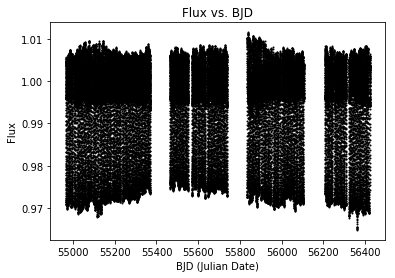

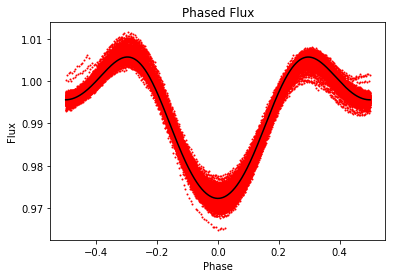

In [10]:
par2, cov2, class2, chi2 = classify('05198315.00.lc.data', 3.6423953, "O'Connell Example", 4)
print(class2)

In [8]:
def classify1(data, period, name, N, t0):
    '''Fits an analytical light curve, and classifies binary system based on given photometric data.
    Inputs: data (name of file), string
            period, float
            name of star/label for the graphs, string
            N - number of cosines for fourier fit
    Outputs: flux graph and fitted curve
             final fit coefficients, covariance matrix
             classification of the system'''
    data = np.loadtxt(data, unpack = 'True')
    time = data[0, :]
    flux = data[6, :]
    sigma = data[7, :]

    t0 += period*0.5
    #t0 = time[list(flux).index(min(flux))] + (period*0.5) #centering phase graph on the primary minimum
    #print(time[list(flux).index(min(flux))])

    #calculating phase (decimal portion of time elapsed/period)
    phase = []
    for t in time:
        p = abs((t-t0)/period - int((t-t0)/period))
        phase.append(p)

    phase_arr = np.array(phase)
    phase_arr = phase_arr - 0.5

    #time vs flux graph
    plt.figure()
    plt.plot(time, flux, 'ko', markersize = 1)
    plt.title('Flux vs. BJD')
    plt.xlabel('BJD (Julian Date)')
    plt.ylabel('Flux')
    plt.savefig('{}bjdplot.png'.format(name))

    #phased graph
    plt.figure()
    plt.plot(phase_arr, flux, 'ro', markersize = 1)
    plt.title('Phased Flux')
    plt.xlabel('Phase')
    plt.ylabel('Flux')

    m = sp.mean(flux)
    par0 = [0.02]*2*N
    par, cov = curve_fit(make_fourier(N, m), phase_arr, flux, par0)

    a2 = par[1]
    a4 = par[3]
    #print(a2, a4)

    classification = ''
    if abs(a4) <= abs(a2*(0.125+a2)):
        classification = 'contact'
    if abs(a4) > abs(a2*(0.125+a2)):  
        classification = 'semi-detached or noncontact binary'

    #plot of synthetic curve
    x = np.linspace(-0.5, 0.5, 1000)
    y = (make_fourier(N, m))(x, *par)
    plt.plot(x, y, 'k')
    plt.savefig('{}fluxfitplot.png'.format(name))
    
    chi_squared = np.sum(((((make_fourier(N, m))(phase_arr, *par)) - flux)/sigma)**2)
    reduced_chi_squared = (chi_squared)/(len(phase_arr)-len(par))
    #print ('{0} chi^2 = {1:5.2f}'.format(name, chi_squared))
    #print ('{0} chi^2/d.f. ={1:5.2f}'.format(name, reduced_chi_squared))
    
    return par, cov, classification, reduced_chi_squared


Here's another interesting object: here, instead of seeing periodic minima, we see a periodic brightening instead. That's because this system contains two binary stars in highly elliptic orbits, and when they get very close (periastron), the tidal effects due to that increased gravity creates a periodic increase in light in the system.

semi-detached or noncontact binary


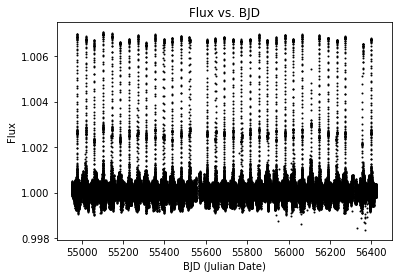

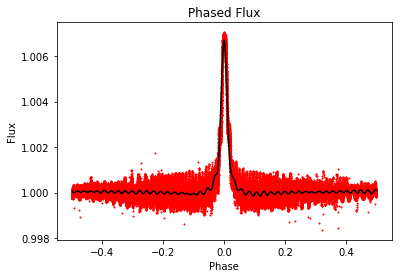

In [6]:
par3, cov3, class3, chi3 = classify1('08112039.00.lc.data', 41.8082351, 'brightening binary', 40, 55019.864444)
print(class3)